In [2]:
# exercise 8.2.6
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import torch
from sklearn import model_selection
from toolbox_02450 import train_neural_net, draw_neural_net
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm import tqdm
from tabulate import tabulate


filename = 'sd-data_cleanedv1.csv'
data = pd.read_csv(filename)

cl_data = data.values

# Getting data and labels separated
X = np.delete(cl_data, 21, axis=1)
y = cl_data[:, 21]

attributeNames = ['SM1','SM2','SM3','HearingL1', 'HearingL2', 'HearingR1', 'HearingR2','sex', 'age', 'height', 'weight', 'waistline', 'sight_left', 'sight_right',
 'SBP' ,'DBP', 'BLDS' ,'tot_chole', 'HDL_chole',
 'LDL_chole', 'triglyceride', 'hemoglobin', 'urine_protein',
 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT' ,'gamma_GTP',
 'DRK_YN']


In [3]:
y_new = np.empty((len(y), 1))
for i in range(len(y_new)):
    y_new[i, 0] = y[i]

y=y_new

In [4]:
X, X_trash, y, y_trash = train_test_split(X, y, test_size=0.90, random_state=42)

In [7]:

N, M = X.shape

# Parameters for neural network classifier
n_hidden_units = range(2,6)        # number of hidden units
n_replicates = 2        # number of networks trained in each k-fold
max_iter = 1000

K_outer = 10  # Number of outer folds
K_inner = 3  # Number of inner folds

# Getting random splits (train and test 90/10) - for outer cross-validation loop
# We will now be able to use the split() method to generate indices to split data into training and test set.
outer_cv = KFold(n_splits=K_outer, shuffle=True)

# Initialize variable - this will contain the test error of the best model when tested on D_test (outer)
final_preformance_for_k_outer = np.empty((2, K_outer))

# Setup figure for display of learning curves and error rates in fold
#summaries, summaries_axes = plt.subplots(1,2, figsize=(10,5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']

loss_fn = torch.nn.MSELoss() # notice how this is now a mean-squared-error loss

errors = [] # make a list for storing generalizaition error in each loop

for i_outer, (train_outer_index, test_outer_index) in enumerate(outer_cv.split(X)):
    print(f'Outer Fold {i_outer + 1}/{K_outer}')

    # train_outer_index and test_outer_index is a list of indicies as the name suggests.
    # we now assign the data, in allignment with the splits, to varaibles
    X_train_outer, X_test_outer = X[train_outer_index, :], X[test_outer_index, :]
    y_train_outer, y_test_outer = y[train_outer_index], y[test_outer_index]

    # Inner splits
    inner_cv = KFold(n_splits=K_inner, shuffle=True)
    # to keep track of all validation errors
    # rows corresponds to the i'th inner split. Cols is the different models
    error_inner = np.empty((K_inner, len(n_hidden_units)))

    for i_inner, (train_inner_index, val_inner_index) in tqdm(enumerate(inner_cv.split(X_train_outer)), total = K_inner):
        X_train_inner, X_val_inner = X_train_outer[train_inner_index, :], X_train_outer[val_inner_index, :]
        y_train_inner, y_val_inner = y_train_outer[train_inner_index], y_train_outer[val_inner_index]

        for k in range(len(n_hidden_units)):
            # Define the model
            model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units[k]), #M features to n_hidden_units
                    torch.nn.Tanh(),   # 1st transfer function,
                    torch.nn.Linear(n_hidden_units[k], 1), # n_hidden_units to 1 output neuron
                    # no final tranfer function, i.e. "linear output"
                    )


            # Extract training and test set for current CV fold, convert to tensors
            X_train = torch.Tensor(X_train_inner)
            y_train = torch.Tensor(y_train_inner)
            X_val = torch.Tensor(X_val_inner)
            y_val = torch.Tensor(y_val_inner)

            net, final_loss, learning_curve = train_neural_net(model, loss_fn, X=X_train, y=y_train, n_replicates=n_replicates, max_iter=max_iter)

            y_val_est = net(X_val)

            # Determine errors and errors
            se = (y_val_est.float()-y_val.float())**2 # squared error
            mse = (sum(se).type(torch.float)/len(y_val)).data.numpy() #mean
            error_inner[i_inner, k] = mse
    
    avg_inner = np.mean(error_inner, axis=0)

    model = lambda: torch.nn.Sequential(
                torch.nn.Linear(M, n_hidden_units[np.argmin(avg_inner)]), #M features to n_hidden_units
                torch.nn.Tanh(),   # 1st transfer function,
                torch.nn.Linear(n_hidden_units[np.argmin(avg_inner)], 1), # n_hidden_units to 1 output neuron
                # no final tranfer function, i.e. "linear output"
                )

    X_train = torch.Tensor(X_train_outer)
    y_train = torch.Tensor(y_train_outer)
    X_test = torch.Tensor(X_test_outer)
    y_test = torch.Tensor(y_test_outer)

    net, final_loss, learning_curve = train_neural_net(model, loss_fn, X=X_train, y=y_train, n_replicates=n_replicates, max_iter=max_iter)

    y_test_est = net(X_test)

    se = (y_test_est.float()-y_test.float())**2 # squared error
    mse = (sum(se).type(torch.float)/len(y_test)).data.numpy() #mean

    final_preformance_for_k_outer[0, i_outer] = mse
    final_preformance_for_k_outer[1, i_outer] = n_hidden_units[np.argmin(avg_inner)] # Also saving num of neighbors for the best model

################## output
list1 = ['Outer_1', 'Outer_2', 'Outer_3', 'Outer_4', 'Outer_5', 'Outer_6', 'Outer_7', 'Outer_8', 'Outer_9', 'Outer_10']

table_data = [
    ['E_i'] + [final_preformance_for_k_outer[0, i] for i in range(K_outer)], # +1
    ['Parameter'] + list(final_preformance_for_k_outer[1, :])
]

# Printing all test errors along with the num of neighbors - based on best model for each outer loop
print(tabulate(table_data, headers=list1, tablefmt='orgtbl'))
# printing generalization error
print(f'E_gen = {(1-float(np.mean(final_preformance_for_k_outer[0, :], axis=0)))*100}%')


                                                     

Outer Fold 1/10


  0%|          | 0/3 [00:00<?, ?it/s]


	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.49604517	0.00010314647
		Final loss:
		1000	0.49604517	0.00010314647

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.47006816	5.8958525e-05
		Final loss:
		1000	0.47006816	5.8958525e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47390577	6.206522e-05
		Final loss:
		1000	0.47390577	6.206522e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.4815596	0.00015209532
		Final loss:
		1000	0.4815596	0.00015209532

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.46983993	4.078434e-05
		Final loss:
		1000	0.46983993	4.078434e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.46990016	3.4754416e-05
		Final loss:
		1000	0.46990016	3.4754416e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47155845	4.0003768e-05
		Final loss:
		1000	0.47155845	4.0003768e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


 33%|███▎      | 1/3 [00:33<01:06, 33.15s/it]

		1000	0.47731608	9.040102e-05
		Final loss:
		1000	0.47731608	9.040102e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4970595	0.00012469554
		Final loss:
		1000	0.4970595	0.00012469554

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.529301	0.00010933247
		Final loss:
		1000	0.529301	0.00010933247

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.5164249	0.00016871242
		Final loss:
		1000	0.5164249	0.00016871242

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.48519728	6.915763e-05
		Final loss:
		1000	0.48519728	6.915763e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.475356	5.855346e-05
		Final loss:
		1000	0.475356	5.855346e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.5034049	0.00015307163
		Final loss:
		1000	0.5034049	0.00015307163

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48035368	4.5785237e-05
		Final loss:
		1000	0.48035368	4.5785237e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


 67%|██████▋   | 2/3 [01:07<00:34, 34.04s/it]

		1000	0.48163065	6.441081e-05
		Final loss:
		1000	0.48163065	6.441081e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.52408683	0.00016033425
		Final loss:
		1000	0.52408683	0.00016033425

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.49132702	7.429905e-05
		Final loss:
		1000	0.49132702	7.429905e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.49622852	0.00015522495
		Final loss:
		1000	0.49622852	0.00015522495

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.48678082	9.1704074e-05
		Final loss:
		1000	0.48678082	9.1704074e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4722824	4.3097327e-05
		Final loss:
		1000	0.4722824	4.3097327e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.49286267	9.710186e-05
		Final loss:
		1000	0.49286267	9.710186e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47501197	2.9298792e-05
		Final loss:
		1000	0.47501197	2.9298792e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


100%|██████████| 3/3 [01:42<00:00, 34.14s/it]

		1000	0.47917017	4.5960507e-05
		Final loss:
		1000	0.47917017	4.5960507e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss


		1000	0.5263853	0.0001660865
		Final loss:
		1000	0.5263853	0.0001660865

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.47318137	3.8795944e-05
		Final loss:
		1000	0.47318137	3.8795944e-05
Outer Fold 2/10


  0%|          | 0/3 [00:00<?, ?it/s]


	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48358992	5.564632e-05
		Final loss:
		1000	0.48358992	5.564632e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.5155665	0.0001692244
		Final loss:
		1000	0.5155665	0.0001692244

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4849209	8.1855505e-05
		Final loss:
		1000	0.4849209	8.1855505e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.5205235	0.0001320115
		Final loss:
		1000	0.5205235	0.0001320115

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47617704	6.1518884e-05
		Final loss:
		1000	0.47617704	6.1518884e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.48190612	7.723543e-05
		Final loss:
		1000	0.48190612	7.723543e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48470426	0.00012320193
		Final loss:
		1000	0.48470426	0.00012320193

	Replicate: 2/2
		Iter	Loss			Rel. loss


 33%|███▎      | 1/3 [00:34<01:09, 34.83s/it]

		1000	0.47809568	5.229673e-05
		Final loss:
		1000	0.47809568	5.229673e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.5099977	0.00013882511
		Final loss:
		1000	0.5099977	0.00013882511

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.5966804	0.00019854936
		Final loss:
		1000	0.5966804	0.00019854936

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.5112519	9.2677015e-05
		Final loss:
		1000	0.5112519	9.2677015e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.52042574	0.00016386635
		Final loss:
		1000	0.52042574	0.00016386635

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.489759	9.905561e-05
		Final loss:
		1000	0.489759	9.905561e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.48408806	0.000115295785
		Final loss:
		1000	0.48408806	0.000115295785

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47594488	4.7524176e-05
		Final loss:
		1000	0.47594488	4.7524176e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


 67%|██████▋   | 2/3 [01:10<00:35, 35.13s/it]

		1000	0.46667436	4.412605e-05
		Final loss:
		1000	0.46667436	4.412605e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.50083524	0.000120424105
		Final loss:
		1000	0.50083524	0.000120424105

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.5023174	0.00010061298
		Final loss:
		1000	0.5023174	0.00010061298

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48793206	9.728912e-05
		Final loss:
		1000	0.48793206	9.728912e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.4875012	6.5346714e-05
		Final loss:
		1000	0.4875012	6.5346714e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.49586934	0.000105406325
		Final loss:
		1000	0.49586934	0.000105406325

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.47365245	4.52376e-05
		Final loss:
		1000	0.47365245	4.52376e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47556424	5.2011146e-05
		Final loss:
		1000	0.47556424	5.2011146e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


100%|██████████| 3/3 [01:44<00:00, 34.79s/it]

		1000	0.47539318	3.936767e-05
		Final loss:
		1000	0.47539318	3.936767e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss


		1000	0.545869	0.00018188114
		Final loss:
		1000	0.545869	0.00018188114

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.47316346	3.9679137e-05
		Final loss:
		1000	0.47316346	3.9679137e-05
Outer Fold 3/10


  0%|          | 0/3 [00:00<?, ?it/s]


	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4958495	9.35725e-05
		Final loss:
		1000	0.4958495	9.35725e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.4912842	5.5745346e-05
		Final loss:
		1000	0.4912842	5.5745346e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.51546174	0.00016359464
		Final loss:
		1000	0.51546174	0.00016359464

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.48139593	3.992915e-05
		Final loss:
		1000	0.48139593	3.992915e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47838357	5.6251898e-05
		Final loss:
		1000	0.47838357	5.6251898e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.4977144	0.00011537229
		Final loss:
		1000	0.4977144	0.00011537229

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.49118453	8.5725565e-05
		Final loss:
		1000	0.49118453	8.5725565e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


 33%|███▎      | 1/3 [00:34<01:09, 34.70s/it]

		1000	0.4957616	6.846541e-05
		Final loss:
		1000	0.4957616	6.846541e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47889373	3.0056959e-05
		Final loss:
		1000	0.47889373	3.0056959e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.4739782	6.337599e-05
		Final loss:
		1000	0.4739782	6.337599e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.5047951	0.00010968142
		Final loss:
		1000	0.5047951	0.00010968142

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.50270736	0.00017900455
		Final loss:
		1000	0.50270736	0.00017900455

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47093186	2.556597e-05
		Final loss:
		1000	0.47093186	2.556597e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.4736966	3.4098426e-05
		Final loss:
		1000	0.4736966	3.4098426e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47745645	8.9438334e-05
		Final loss:
		1000	0.47745645	8.9438334e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


 67%|██████▋   | 2/3 [01:09<00:34, 34.62s/it]

		1000	0.46831188	3.2072407e-05
		Final loss:
		1000	0.46831188	3.2072407e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48879847	6.998932e-05
		Final loss:
		1000	0.48879847	6.998932e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.5495115	0.00014760373
		Final loss:
		1000	0.5495115	0.00014760373

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.51639754	0.00013606633
		Final loss:
		1000	0.51639754	0.00013606633

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.49077964	6.606383e-05
		Final loss:
		1000	0.49077964	6.606383e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47040007	5.1188435e-05
		Final loss:
		1000	0.47040007	5.1188435e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.48478103	8.943935e-05
		Final loss:
		1000	0.48478103	8.943935e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4773312	4.6574572e-05
		Final loss:
		1000	0.4773312	4.6574572e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


100%|██████████| 3/3 [01:42<00:00, 34.17s/it]

		1000	0.48520643	0.00010489768
		Final loss:
		1000	0.48520643	0.00010489768

	Replicate: 1/2
		Iter	Loss			Rel. loss


		1000	0.52350384	0.00016813871
		Final loss:
		1000	0.52350384	0.00016813871

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.49274078	7.469063e-05
		Final loss:
		1000	0.49274078	7.469063e-05
Outer Fold 4/10


  0%|          | 0/3 [00:00<?, ?it/s]


	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.5030607	9.051358e-05
		Final loss:
		1000	0.5030607	9.051358e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.49838793	0.00012155342
		Final loss:
		1000	0.49838793	0.00012155342

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.52796227	0.00011999368
		Final loss:
		1000	0.52796227	0.00011999368

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.4950755	0.0001148437
		Final loss:
		1000	0.4950755	0.0001148437

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4907192	0.000103415776
		Final loss:
		1000	0.4907192	0.000103415776

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.5080131	0.00016165315
		Final loss:
		1000	0.5080131	0.00016165315

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47698158	4.3547414e-05
		Final loss:
		1000	0.47698158	4.3547414e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


 33%|███▎      | 1/3 [00:35<01:10, 35.01s/it]

		1000	0.4843118	4.479577e-05
		Final loss:
		1000	0.4843118	4.479577e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.53063583	8.8056484e-05
		Final loss:
		1000	0.53063583	8.8056484e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.503116	9.950572e-05
		Final loss:
		1000	0.503116	9.950572e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48793492	7.1273505e-05
		Final loss:
		1000	0.48793492	7.1273505e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.47704583	3.161017e-05
		Final loss:
		1000	0.47704583	3.161017e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47749582	2.958326e-05
		Final loss:
		1000	0.47749582	2.958326e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.4821063	5.841357e-05
		Final loss:
		1000	0.4821063	5.841357e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47713014	7.769622e-05
		Final loss:
		1000	0.47713014	7.769622e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


 67%|██████▋   | 2/3 [01:13<00:36, 36.98s/it]

		1000	0.49501464	0.00014699883
		Final loss:
		1000	0.49501464	0.00014699883

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48366278	9.31577e-05
		Final loss:
		1000	0.48366278	9.31577e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.50464314	0.00012341229
		Final loss:
		1000	0.50464314	0.00012341229

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47846347	0.00010295074
		Final loss:
		1000	0.47846347	0.00010295074

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.5157063	0.00011787634
		Final loss:
		1000	0.5157063	0.00011787634

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4737473	4.5983365e-05
		Final loss:
		1000	0.4737473	4.5983365e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.481779	3.4454224e-05
		Final loss:
		1000	0.481779	3.4454224e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.46512046	2.1592612e-05
		Final loss:
		1000	0.46512046	2.1592612e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


100%|██████████| 3/3 [01:46<00:00, 35.63s/it]

		1000	0.4826999	5.4390766e-05
		Final loss:
		1000	0.4826999	5.4390766e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss


		1000	0.47884545	4.5182656e-05
		Final loss:
		1000	0.47884545	4.5182656e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.47521323	8.290048e-05
		Final loss:
		1000	0.47521323	8.290048e-05
Outer Fold 5/10


  0%|          | 0/3 [00:00<?, ?it/s]


	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.50306207	0.000116692805
		Final loss:
		1000	0.50306207	0.000116692805

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.5049315	9.419105e-05
		Final loss:
		1000	0.5049315	9.419105e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.49547547	0.00013531679
		Final loss:
		1000	0.49547547	0.00013531679

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.51010025	0.00010655483
		Final loss:
		1000	0.51010025	0.00010655483

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47524172	4.6403115e-05
		Final loss:
		1000	0.47524172	4.6403115e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.47319213	3.363096e-05
		Final loss:
		1000	0.47319213	3.363096e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4780432	5.0681738e-05
		Final loss:
		1000	0.4780432	5.0681738e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


 33%|███▎      | 1/3 [00:33<01:06, 33.39s/it]

		1000	0.46370476	5.1541912e-05
		Final loss:
		1000	0.46370476	5.1541912e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.485916	7.6536795e-05
		Final loss:
		1000	0.485916	7.6536795e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.51073074	0.00011494085
		Final loss:
		1000	0.51073074	0.00011494085

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48001617	1.58317e-05
		Final loss:
		1000	0.48001617	1.58317e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.49823725	0.00013935076
		Final loss:
		1000	0.49823725	0.00013935076

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47716424	6.482633e-05
		Final loss:
		1000	0.47716424	6.482633e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.49350888	0.00011937406
		Final loss:
		1000	0.49350888	0.00011937406

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.5060739	0.000121532685
		Final loss:
		1000	0.5060739	0.000121532685

	Replicate: 2/2
		Iter	Loss			Rel. loss


 67%|██████▋   | 2/3 [01:07<00:33, 33.76s/it]

		1000	0.48376817	5.8890488e-05
		Final loss:
		1000	0.48376817	5.8890488e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.52431816	0.00012275965
		Final loss:
		1000	0.52431816	0.00012275965

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.4800295	4.1160234e-05
		Final loss:
		1000	0.4800295	4.1160234e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.49812648	0.000106244705
		Final loss:
		1000	0.49812648	0.000106244705

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.49902228	0.00017190842
		Final loss:
		1000	0.49902228	0.00017190842

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48659262	8.726931e-05
		Final loss:
		1000	0.48659262	8.726931e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.47609654	5.2516312e-05
		Final loss:
		1000	0.47609654	5.2516312e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.49685547	0.00015886674
		Final loss:
		1000	0.49685547	0.00015886674

	Replicate: 2/2
		Iter	Loss			Rel. loss


100%|██████████| 3/3 [01:41<00:00, 33.99s/it]

		1000	0.4696585	6.1420964e-05
		Final loss:
		1000	0.4696585	6.1420964e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss


		1000	0.47929525	6.484897e-05
		Final loss:
		1000	0.47929525	6.484897e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.47323558	5.7367535e-05
		Final loss:
		1000	0.47323558	5.7367535e-05
Outer Fold 6/10


  0%|          | 0/3 [00:00<?, ?it/s]


	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.5325322	0.000160813
		Final loss:
		1000	0.5325322	0.000160813

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.4769083	6.111215e-05
		Final loss:
		1000	0.4769083	6.111215e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4837059	0.000112306945
		Final loss:
		1000	0.4837059	0.000112306945

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.5227189	0.00012017118
		Final loss:
		1000	0.5227189	0.00012017118

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48510048	9.988392e-05
		Final loss:
		1000	0.48510048	9.988392e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.47964823	7.4244264e-05
		Final loss:
		1000	0.47964823	7.4244264e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.476347	3.9163726e-05
		Final loss:
		1000	0.476347	3.9163726e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


 33%|███▎      | 1/3 [00:34<01:08, 34.08s/it]

		1000	0.47308192	4.2394586e-05
		Final loss:
		1000	0.47308192	4.2394586e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48388287	4.9269533e-05
		Final loss:
		1000	0.48388287	4.9269533e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.48576316	7.686758e-05
		Final loss:
		1000	0.48576316	7.686758e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.5079872	9.163019e-05
		Final loss:
		1000	0.5079872	9.163019e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.52043456	0.00017496909
		Final loss:
		1000	0.52043456	0.00017496909

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47980973	6.1612096e-05
		Final loss:
		1000	0.47980973	6.1612096e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.4779162	4.445991e-05
		Final loss:
		1000	0.4779162	4.445991e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47625062	4.69931e-05
		Final loss:
		1000	0.47625062	4.69931e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


 67%|██████▋   | 2/3 [01:08<00:34, 34.16s/it]

		1000	0.48248687	4.6447494e-05
		Final loss:
		1000	0.48248687	4.6447494e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48799983	8.927689e-05
		Final loss:
		1000	0.48799983	8.927689e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.49980825	9.915072e-05
		Final loss:
		1000	0.49980825	9.915072e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.49735484	0.000114796705
		Final loss:
		1000	0.49735484	0.000114796705

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.52619463	0.00012402063
		Final loss:
		1000	0.52619463	0.00012402063

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47798312	4.9316543e-05
		Final loss:
		1000	0.47798312	4.9316543e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.48732105	7.680531e-05
		Final loss:
		1000	0.48732105	7.680531e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.49598268	0.00013920318
		Final loss:
		1000	0.49598268	0.00013920318

	Replicate: 2/2
		Iter	Loss			Rel. loss


100%|██████████| 3/3 [01:42<00:00, 34.31s/it]

		1000	0.52619886	0.00011915004
		Final loss:
		1000	0.52619886	0.00011915004

	Replicate: 1/2
		Iter	Loss			Rel. loss


		1000	0.4758987	4.05156e-05
		Final loss:
		1000	0.4758987	4.05156e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.47728184	6.112675e-05
		Final loss:
		1000	0.47728184	6.112675e-05
Outer Fold 7/10


  0%|          | 0/3 [00:00<?, ?it/s]


	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47652286	2.7830069e-05
		Final loss:
		1000	0.47652286	2.7830069e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.5291432	0.00010925244
		Final loss:
		1000	0.5291432	0.00010925244

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4972923	0.00012475699
		Final loss:
		1000	0.4972923	0.00012475699

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.46849227	3.4222765e-05
		Final loss:
		1000	0.46849227	3.4222765e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48912686	0.000102290396
		Final loss:
		1000	0.48912686	0.000102290396

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.48248872	0.00010351231
		Final loss:
		1000	0.48248872	0.00010351231

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.49273938	0.00010547111
		Final loss:
		1000	0.49273938	0.00010547111

	Replicate: 2/2
		Iter	Loss			Rel. loss


 33%|███▎      | 1/3 [00:33<01:07, 33.97s/it]

		1000	0.4870371	7.91138e-05
		Final loss:
		1000	0.4870371	7.91138e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.49019575	8.000216e-05
		Final loss:
		1000	0.49019575	8.000216e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.5084305	0.00012929087
		Final loss:
		1000	0.5084305	0.00012929087

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48534566	5.4524065e-05
		Final loss:
		1000	0.48534566	5.4524065e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.47703657	3.4671797e-05
		Final loss:
		1000	0.47703657	3.4671797e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.46887788	3.6291985e-05
		Final loss:
		1000	0.46887788	3.6291985e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.47596732	5.3031432e-05
		Final loss:
		1000	0.47596732	5.3031432e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.46297553	5.8445698e-05
		Final loss:
		1000	0.46297553	5.8445698e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


 67%|██████▋   | 2/3 [01:07<00:33, 33.85s/it]

		1000	0.4722149	4.3797656e-05
		Final loss:
		1000	0.4722149	4.3797656e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.49144262	6.767248e-05
		Final loss:
		1000	0.49144262	6.767248e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.48601723	8.749524e-05
		Final loss:
		1000	0.48601723	8.749524e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.5382939	0.00022993087
		Final loss:
		1000	0.5382939	0.00022993087

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.48242578	4.3735476e-05
		Final loss:
		1000	0.48242578	4.3735476e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4878385	0.000116058574
		Final loss:
		1000	0.4878385	0.000116058574

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.4855297	7.715003e-05
		Final loss:
		1000	0.4855297	7.715003e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47465345	3.5097004e-05
		Final loss:
		1000	0.47465345	3.5097004e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


100%|██████████| 3/3 [01:42<00:00, 34.05s/it]

		1000	0.46816027	7.269258e-05
		Final loss:
		1000	0.46816027	7.269258e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss


		1000	0.47582495	3.9457205e-05
		Final loss:
		1000	0.47582495	3.9457205e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.47382373	8.389821e-05
		Final loss:
		1000	0.47382373	8.389821e-05
Outer Fold 8/10


  0%|          | 0/3 [00:00<?, ?it/s]


	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.52705526	0.00018034592
		Final loss:
		1000	0.52705526	0.00018034592

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.49969223	7.4665404e-05
		Final loss:
		1000	0.49969223	7.4665404e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4872624	4.9233615e-05
		Final loss:
		1000	0.4872624	4.9233615e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.5032065	0.00012139618
		Final loss:
		1000	0.5032065	0.00012139618

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47688484	2.7371514e-05
		Final loss:
		1000	0.47688484	2.7371514e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.47839698	5.2201503e-05
		Final loss:
		1000	0.47839698	5.2201503e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.5230364	0.00019209777
		Final loss:
		1000	0.5230364	0.00019209777

	Replicate: 2/2
		Iter	Loss			Rel. loss


 33%|███▎      | 1/3 [00:33<01:06, 33.46s/it]

		1000	0.4814076	3.19428e-05
		Final loss:
		1000	0.4814076	3.19428e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4683774	4.065719e-05
		Final loss:
		1000	0.4683774	4.065719e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.48261723	7.792428e-05
		Final loss:
		1000	0.48261723	7.792428e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48469764	8.281535e-05
		Final loss:
		1000	0.48469764	8.281535e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.49586672	0.0001705389
		Final loss:
		1000	0.49586672	0.0001705389

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47526008	3.1917047e-05
		Final loss:
		1000	0.47526008	3.1917047e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.49368334	0.00013538549
		Final loss:
		1000	0.49368334	0.00013538549

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47046772	2.711142e-05
		Final loss:
		1000	0.47046772	2.711142e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


 67%|██████▋   | 2/3 [01:06<00:33, 33.24s/it]

		1000	0.4719003	4.357426e-05
		Final loss:
		1000	0.4719003	4.357426e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4808382	0.00010392955
		Final loss:
		1000	0.4808382	0.00010392955

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.49241456	9.5979995e-05
		Final loss:
		1000	0.49241456	9.5979995e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.49883863	0.00013900359
		Final loss:
		1000	0.49883863	0.00013900359

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.507321	0.00012217365
		Final loss:
		1000	0.507321	0.00012217365

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.46963847	2.8238017e-05
		Final loss:
		1000	0.46963847	2.8238017e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.48611292	5.9464648e-05
		Final loss:
		1000	0.48611292	5.9464648e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.50254405	0.00012914505
		Final loss:
		1000	0.50254405	0.00012914505

	Replicate: 2/2
		Iter	Loss			Rel. loss


100%|██████████| 3/3 [01:39<00:00, 33.11s/it]

		1000	0.4773659	4.856878e-05
		Final loss:
		1000	0.4773659	4.856878e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss


		1000	0.477429	4.2445514e-05
		Final loss:
		1000	0.477429	4.2445514e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.49848688	0.00015452183
		Final loss:
		1000	0.49848688	0.00015452183
Outer Fold 9/10


  0%|          | 0/3 [00:00<?, ?it/s]


	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48709613	3.175331e-05
		Final loss:
		1000	0.48709613	3.175331e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.50031835	9.9109195e-05
		Final loss:
		1000	0.50031835	9.9109195e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.49462357	8.464764e-05
		Final loss:
		1000	0.49462357	8.464764e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.48607782	5.05184e-05
		Final loss:
		1000	0.48607782	5.05184e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48688325	8.880841e-05
		Final loss:
		1000	0.48688325	8.880841e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.4856149	8.584965e-05
		Final loss:
		1000	0.4856149	8.584965e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47725907	5.201377e-05
		Final loss:
		1000	0.47725907	5.201377e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


 33%|███▎      | 1/3 [00:33<01:07, 33.63s/it]

		1000	0.49114224	7.4205665e-05
		Final loss:
		1000	0.49114224	7.4205665e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.52465904	0.00019525134
		Final loss:
		1000	0.52465904	0.00019525134

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.488549	0.000116743635
		Final loss:
		1000	0.488549	0.000116743635

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47571838	4.7170954e-05
		Final loss:
		1000	0.47571838	4.7170954e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.47683814	6.187105e-05
		Final loss:
		1000	0.47683814	6.187105e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4778122	7.926911e-05
		Final loss:
		1000	0.4778122	7.926911e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.48480564	6.712371e-05
		Final loss:
		1000	0.48480564	6.712371e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4922234	0.00015358246
		Final loss:
		1000	0.4922234	0.00015358246

	Replicate: 2/2
		Iter	Loss			Rel. loss


 67%|██████▋   | 2/3 [01:07<00:34, 34.05s/it]

		1000	0.49405095	0.00015126562
		Final loss:
		1000	0.49405095	0.00015126562

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48442295	6.250172e-05
		Final loss:
		1000	0.48442295	6.250172e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.50957894	9.064231e-05
		Final loss:
		1000	0.50957894	9.064231e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48717493	8.5758256e-05
		Final loss:
		1000	0.48717493	8.5758256e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.50191	0.00015863238
		Final loss:
		1000	0.50191	0.00015863238

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4783394	4.1554853e-05
		Final loss:
		1000	0.4783394	4.1554853e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.4780382	5.9097645e-05
		Final loss:
		1000	0.4780382	5.9097645e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.47426793	3.2863496e-05
		Final loss:
		1000	0.47426793	3.2863496e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


100%|██████████| 3/3 [01:42<00:00, 34.20s/it]

		1000	0.46529868	3.234414e-05
		Final loss:
		1000	0.46529868	3.234414e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss


		1000	0.5029839	0.00013080919
		Final loss:
		1000	0.5029839	0.00013080919

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.49292913	0.00018007687
		Final loss:
		1000	0.49292913	0.00018007687
Outer Fold 10/10


  0%|          | 0/3 [00:00<?, ?it/s]


	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.50731784	0.00012405378
		Final loss:
		1000	0.50731784	0.00012405378

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.49507773	7.2532435e-05
		Final loss:
		1000	0.49507773	7.2532435e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48562574	5.025861e-05
		Final loss:
		1000	0.48562574	5.025861e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.4840719	6.901061e-05
		Final loss:
		1000	0.4840719	6.901061e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48169082	5.9577484e-05
		Final loss:
		1000	0.48169082	5.9577484e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.4763979	5.9738966e-05
		Final loss:
		1000	0.4763979	5.9738966e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4780778	5.815779e-05
		Final loss:
		1000	0.4780778	5.815779e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


 33%|███▎      | 1/3 [00:34<01:09, 34.95s/it]

		1000	0.47306877	5.3482327e-05
		Final loss:
		1000	0.47306877	5.3482327e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.5011868	7.503731e-05
		Final loss:
		1000	0.5011868	7.503731e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.5293793	0.0001639092
		Final loss:
		1000	0.5293793	0.0001639092

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.53580445	0.00019541624
		Final loss:
		1000	0.53580445	0.00019541624

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.48007226	5.5060886e-05
		Final loss:
		1000	0.48007226	5.5060886e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48415023	9.1094495e-05
		Final loss:
		1000	0.48415023	9.1094495e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.48754933	9.272073e-05
		Final loss:
		1000	0.48754933	9.272073e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.46860945	4.012832e-05
		Final loss:
		1000	0.46860945	4.012832e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


 67%|██████▋   | 2/3 [01:08<00:34, 34.34s/it]

		1000	0.48617545	8.9060275e-05
		Final loss:
		1000	0.48617545	8.9060275e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.5042531	0.00014584225
		Final loss:
		1000	0.5042531	0.00014584225

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.49978948	0.00010928939
		Final loss:
		1000	0.49978948	0.00010928939

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4826746	5.9888218e-05
		Final loss:
		1000	0.4826746	5.9888218e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.49146244	0.00012096233
		Final loss:
		1000	0.49146244	0.00012096233

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.48011306	5.0587383e-05
		Final loss:
		1000	0.48011306	5.0587383e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.47129497	3.066802e-05
		Final loss:
		1000	0.47129497	3.066802e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss
		1000	0.4680818	3.705401e-05
		Final loss:
		1000	0.4680818	3.705401e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss


100%|██████████| 3/3 [01:42<00:00, 34.25s/it]

		1000	0.47606376	5.3333664e-05
		Final loss:
		1000	0.47606376	5.3333664e-05

	Replicate: 1/2
		Iter	Loss			Rel. loss


		1000	0.48039117	5.4962304e-05
		Final loss:
		1000	0.48039117	5.4962304e-05

	Replicate: 2/2
		Iter	Loss			Rel. loss
		1000	0.47443298	4.3781336e-05
		Final loss:
		1000	0.47443298	4.3781336e-05
|           |   Outer_1 |   Outer_2 |   Outer_3 |   Outer_4 |   Outer_5 |   Outer_6 |   Outer_7 |   Outer_8 |   Outer_9 |   Outer_10 |
|-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------|
| E_i       |  0.478016 |  0.479551 |  0.487397 |  0.460856 |  0.476809 |  0.470195 |  0.476997 |  0.490311 |  0.509654 |    0.46178 |
| Parameter |  4        |  5        |  4        |  5        |  5        |  4        |  5        |  4        |  5        |    5       |
E_gen = 52.08433955907822%


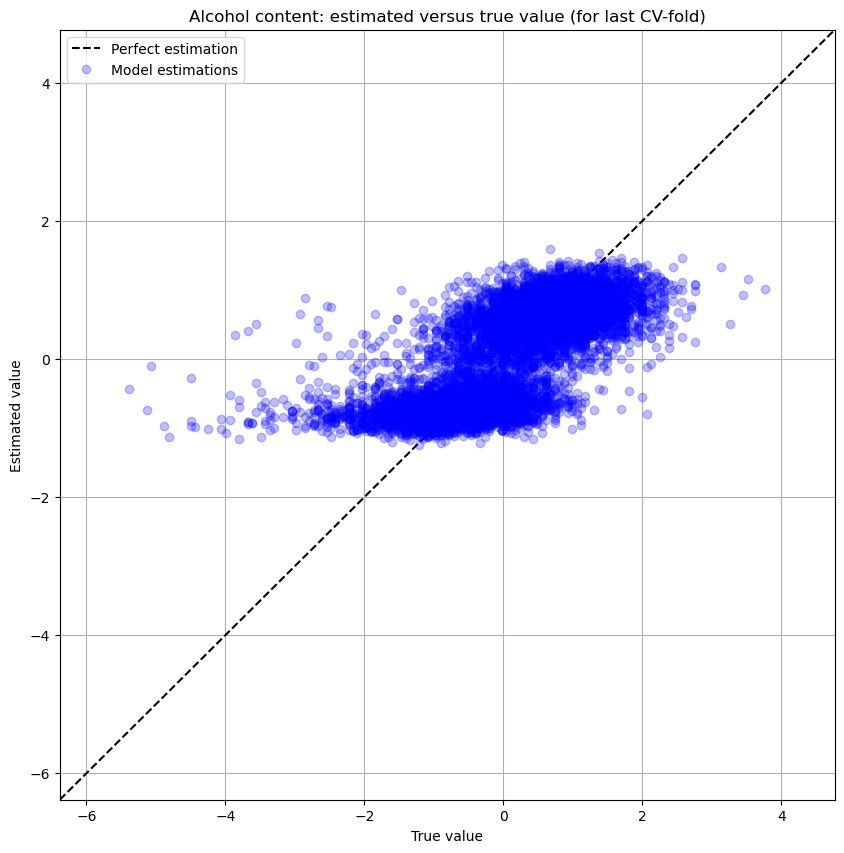

In [8]:
plt.figure(figsize=(10,10))
y_est = y_test_est.data.numpy(); y_true = y_test.data.numpy()
axis_range = [np.min([y_est, y_true])-1,np.max([y_est, y_true])+1]
plt.plot(axis_range,axis_range,'k--')
plt.plot(y_true, y_est,'ob',alpha=.25)
plt.legend(['Perfect estimation','Model estimations'])
plt.title('Alcohol content: estimated versus true value (for last CV-fold)')
plt.ylim(axis_range); plt.xlim(axis_range)
plt.xlabel('True value')
plt.ylabel('Estimated value')
plt.grid()

plt.show()